In [71]:
import numpy as np
import matplotlib.pyplot as plt

import scienceplots
plt.style.use(["science", "grid"]) 

plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 150

In [72]:
# Constants

h = 500 # km
mu = 398600 # km^3/s^2
R_E = 6378

# Orbital velocity
def v_orb(h):
    return np.sqrt(mu / (h + 6378.1))

v = v_orb(h)
# Track velocity
v_t = v * (1 - (h/R_E))
spin_rate = v_t / R_E

t_span = 60 # seconds

# Spacecraft state
x_0 = np.array([0, 0, 0, 1, 0, 0, 0])
# Inertia matrix
J = np.eye(3)

dt = 0.1

print(v_t)
print(v)


7.01583668851148
7.61262442996363


In [73]:
# Helpers

def intersect_ray_sphere(P, u, x0, r):
    """
    Determines the intersections of a ray with a sphere.
    
    Parameters:
    P (numpy array): The starting point of the ray (3D vector).
    u (numpy array): The direction of the ray (3D vector).
    x0 (numpy array): The center of the sphere (3D vector).
    r (float): The radius of the sphere.
    
    Returns:
    t1, t2 (float, float): The parameter values at which the intersections occur.
    None if there are no intersections.
    """
    # Normalize direction vector
    u = u / np.linalg.norm(u)
    
    # Compute coefficients of the quadratic equation
    A = np.dot(u, u)
    B = 2 * np.dot(u, P - x0)
    C = np.dot(P - x0, P - x0) - r**2
    
    # Compute the discriminant
    discriminant = B**2 - 4*A*C
    
    if discriminant < 0:
        # No intersection
        return None
    elif discriminant == 0:
        # One intersection (tangent)
        t = -B / (2*A)
        return (P + t * u,)
    else:
        # Two intersections
        sqrt_disc = np.sqrt(discriminant)
        t1 = (-B + sqrt_disc) / (2*A)
        t2 = (-B - sqrt_disc) / (2*A)
        print(t1)
        print(t2)
        return (P + t1 * u, P + t2 * u)
    
def earth_line_intersection(P, u):
    return intersect_ray_sphere(P, u, np.array([0, 0, -R_E]), R_E)

# Dynamics

def qdot_matrix(q):
    qw, qx, qy, qz = q
    return np.array([
        [-qx, -qy, -qz],
        [qw, -qz, qy],
        [qz, qw, -qx],
        [-qy, qx, qw]
    ])

def qdot(q, w):
    return 0.5 * qdot_matrix(q) @ w

def euler_eqn(w, u, J, Jinv):
    return Jinv @ (u - np.cross(w, J @ w))

def xdot(x, u, J, Jinv):
    w = x[:3]
    q = x[3:]

    w_dot = euler_eqn(w, u, J, Jinv)
    q_dot = qdot(q, w)

    return np.concatenate([w_dot, q_dot])

def q2mat(q, homogenous=False):
    w, x, y, z = q
    if(not homogenous):
        return np.array([
            [1 - 2*y**2 - 2*z**2, 2*x*y - 2*z*w, 2*x*z + 2*y*w],
            [2*x*y + 2*z*w, 1 - 2*x**2 - 2*z**2, 2*y*z - 2*x*w],
            [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2*x**2 - 2*y**2]
        ])
    return np.array([
        [1 - 2*y**2 - 2*z**2, 2*x*y - 2*z*w, 2*x*z + 2*y*w, 0],
        [2*x*y + 2*z*w, 1 - 2*x**2 - 2*z**2, 2*y*z - 2*x*w, 0],
        [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2*x**2 - 2*y**2, 0],
        [0, 0, 0, 1]
    ])

def eul2q(yaw, pitch, roll):
    # Calculate the half angles
    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)
    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)

    # Calculate the quaternion
    w = cr * cp * cy + sr * sp * sy
    x = sr * cp * cy - cr * sp * sy
    y = cr * sp * cy + sr * cp * sy
    z = cr * cp * sy - sr * sp * cy

    return (w, x, y, z)

def eul2R(roll, pitch, yaw):
    
    # Calculate rotation matrix for roll (around x-axis)
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(roll), -np.sin(roll)],
                    [0, np.sin(roll), np.cos(roll)]])
    
    # Calculate rotation matrix for pitch (around y-axis)
    R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                    [0, 1, 0],
                    [-np.sin(pitch), 0, np.cos(pitch)]])
    
    # Calculate rotation matrix for yaw (around z-axis)
    R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                    [np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]])
    
    # Combine the rotations
    R = np.dot(R_z, np.dot(R_y, R_x))
    
    return R



In [74]:
# Nadir instrument
c = np.array([0, 0, 1])
x = eul2q(0, np.deg2rad(10), 0)
print(x)
# Find intersections...
x_eci = q2mat(x) @ c
earth_line_intersection([0, 0, h], x_eci)[1]

(0.9961946980917455, 0.0, 0.08715574274765817, 0.0)
-508.33359327338974
-13038.68185716254


array([ -2264.14334368,      0.        , -12340.59498199])

In [106]:
# Instrument design and camera matrices
pitch = 5e-6
width = 1200
height = 800
c_x = width/2
c_y = height/2
f = 8e-3 / pitch

K = np.hstack([np.array([-f, 0, c_x, 0, -f, c_y, 0, 0, 1]).reshape(3,3), np.zeros((3,1))])

def get_extrinsics(q, p):
    R_q = q2mat(q)
    R_0 = eul2R(0, np.pi, -np.pi/2) # boresight on -z
    R = R_0 @ R_q
    print(R_q)
    t = -R @ p
    return np.block([[R, t.reshape(3,1)], [0, 0, 0, 1]])

def get_camera_matrix(q, p):
    return K @ get_extrinsics(q, p)

# P = get_camera_matrix(np.array([0.99, -0.1, 0, 0]), np.array([0, 0, h]))
P = get_camera_matrix(np.array([1, 0, 0, 0]), np.array([0, 0, h]))

# point in world coordinates
X = np.array([10, 0, 0, 1])

x = P @ X
x /= x[2]
print(x)

[[1 0 0]
 [0 1 0]
 [0 0 1]]
[600. 368.   1.]


[0. 0. 0. 1. 0. 0. 0.]
[-7.01583527e+00  0.00000000e+00 -3.85872997e-03]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0. 0. 0. 1. 0. 0. 0.]
[-14.03166206   0.          -0.01543492]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0. 0. 0. 1. 0. 0. 0.]
[-21.04747186   0.          -0.03472854]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0. 0. 0. 1. 0. 0. 0.]
[-28.0632562    0.          -0.06173959]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0. 0. 0. 1. 0. 0. 0.]
[-35.07900658   0.          -0.09646802]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0. 0. 0. 1. 0. 0. 0.]
[-42.09471452   0.          -0.13891379]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0. 0. 0. 1. 0. 0. 0.]
[-49.11037152   0.          -0.18907685]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0. 0. 0. 1. 0. 0. 0.]
[-56.12596909   0.          -0.24695715]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0. 0. 0. 1. 0. 0. 0.]
[-63.14149876   0.          -0.31255461]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0. 0. 0. 1. 0. 0. 0.]
[-70.15695202   0.          -0.38586914]
[[1. 0. 0.]
 [0. 1

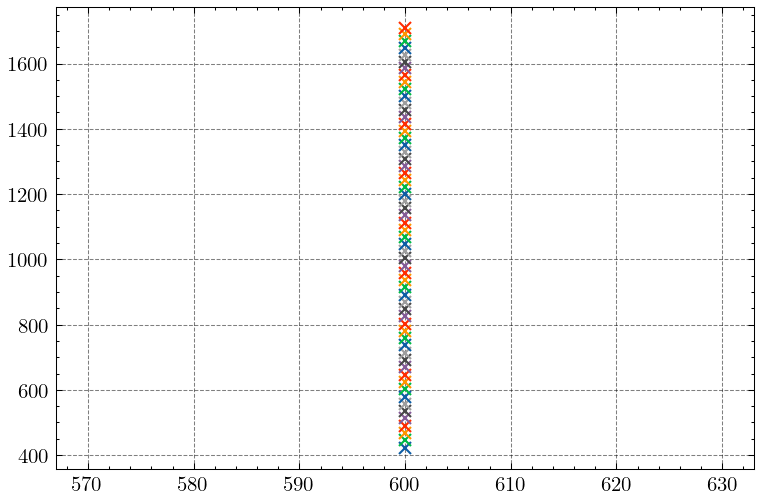

In [115]:
def step_dynamics(x, u, dt):
    Jinv = np.linalg.inv(J)
    k1 = dt * xdot(x, u, J, Jinv)
    k2 = dt * xdot(x + 0.5 * k1, u, J, Jinv)
    k3 = dt * xdot(x + 0.5 * k2, u, J, Jinv)
    k4 = dt * xdot(x + k3, u, J, Jinv)

    return x + (k1 + 2*k2 + 2*k3 + k4) / 6

def step_tasks(x, t):
    # Rotate the tasks
    R = eul2R(0, -spin_rate * t, 0)
    x_0 = np.array([0, 0, R_E])
    return R @ (x + x_0) - x_0
    

x0 = np.array([0.0, 0, 0, 1, 0, 0, 0])

# Rotate tasks

# First generate the task...

# Generate from across/along track

def task_from_track(across, along):
    theta = along / R_E
    phi = across / R_E

    return np.array([R_E * np.sin(theta), R_E * np.cos(theta) * np.sin(phi), R_E * (np.cos(theta) * np.cos(phi) - 1)])

task = task_from_track(0, 0)

t_span = np.linspace(0, 60, 60)
dt = 1

x = x0
# spin_rate = 0
for t in t_span:
    x = step_dynamics(x, np.array([0, 0, 0]), dt)
    # x[0:3] = 0

    print(x)
    task = step_tasks(task, dt)
    print(task)

    P = get_camera_matrix(x[3:], np.array([0, 0, h]))
    x_cam = P @ np.append(task, [1], axis=0)
    x_cam /= x_cam[2]
    # print(x_cam)
    plt.plot(x_cam[0], x_cam[1], 'x')

plt.show()